# Assignment 2

João Bento 

95940

Github link: https://github.com/Joao-Bento/si

## Exercise 1: Regression Problem with ANFIS

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


In [2]:
#Load dataset
diabetes = datasets.load_diabetes(as_frame=True)

X = diabetes.data.values
y = diabetes.target.values

In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [5]:
# Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [6]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

In [7]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)


Fuzzy partition coefficient (FPC): 0.8556218820367708


In [8]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-4, 4, 500)

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

In [9]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



### ANFIS Solver

The only difference between this exercise and exercise 1 of assignment 1 is how the final model is trained. Using a simple least squares solver proved to inefficient in solving this regression problem, and thus a more complex training method was implemented: ANFIS. ANFIS stands for Adaptive Neuro-Fuzzy Inference System and can be defined as an hybrid system that combines fuzzy logic with neural networks, to create more robust models.

It keeps the if-then rationale already described on the previous assignment. Note that on both procedures the modelling is donne with a TSK fuzzy system.

On the other hand, the learning is donne with a more complex solver. ANFIS applies gradient descent training on antecedents of the TSK model (if rules), by minimizing a loss function with parameter optimization. However, consequents (then part) parameters are still identified by a least squares estimator. In sum, it combines forward and backward passes, as node outputs move forward with least squares, and error signals propagate backwards using gradient descent.

In [10]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [11]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()


In [12]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [13]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [14]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))

tensor(2683.3916, grad_fn=<MseLossBackward0>)
tensor(2682.0908, grad_fn=<MseLossBackward0>)
tensor(2680.8711, grad_fn=<MseLossBackward0>)
tensor(2679.6750, grad_fn=<MseLossBackward0>)
tensor(2678.5166, grad_fn=<MseLossBackward0>)
tensor(2677.4028, grad_fn=<MseLossBackward0>)
tensor(2676.3206, grad_fn=<MseLossBackward0>)
tensor(2675.2366, grad_fn=<MseLossBackward0>)
tensor(2674.1299, grad_fn=<MseLossBackward0>)
tensor(2673.0332, grad_fn=<MseLossBackward0>)
tensor(2671.9397, grad_fn=<MseLossBackward0>)
tensor(2670.8508, grad_fn=<MseLossBackward0>)
tensor(2669.7744, grad_fn=<MseLossBackward0>)
tensor(2668.6846, grad_fn=<MseLossBackward0>)
tensor(2667.5984, grad_fn=<MseLossBackward0>)
tensor(2666.5095, grad_fn=<MseLossBackward0>)
tensor(2665.4287, grad_fn=<MseLossBackward0>)
tensor(2664.3721, grad_fn=<MseLossBackward0>)
tensor(2663.3250, grad_fn=<MseLossBackward0>)
tensor(2662.2825, grad_fn=<MseLossBackward0>)
tensor(2658.7925, grad_fn=<MseLossBackward0>)
tensor(2657.5173, grad_fn=<MseLoss

### Model Performance

In [15]:
y_pred, _, _=model(Xte)
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression
print(f'RMSE:{np.sqrt(mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy()))}') 

MSE:2656.486328125
RMSE:51.54111298880729


In [16]:
y_min = y.min()
y_max = y.max()
print(f"y data range: {y_min} to {y_max}")

y data range: 25.0 to 346.0


Although a more robust model was implemented, the performance did not change significantly. In fact, it got slightly worse (recall the MSE and RMSE for exercise 1 of assignment 1: 2545 and 50.45, respectively). Further comparison and improvements are discussed in the next exercise.

## Exercise 2: Regression Problem with Neural Networks

In [17]:
%reset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

In [18]:
#Load dataset
diabetes = datasets.load_diabetes(as_frame=True)

X = diabetes.data.values
y = diabetes.target.values

In [19]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [20]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

### Neural Networks

A neural network is a computational model inspired by the structure and functioning of the human brain. It is composed by nodes and layers. Nodes receive inputs, apply weights and biases and process the data using an activation function, passing the result to the next layer. Layers are collections of nodes, and can receive data (input layers), process data (hidden layers) or produce results (output layers). Furthermore, weights represent the strength of connection between nodes and biases allow the model to shift the activation function to better fit the data.

In the NN architecture implemented below there are six layers (one for input, another for output and four hidden layers in between), each having 64 input and output features (except as global input and output of the network). All layers use ReLU (Rectified Linear Unit) functions as activations.

In [21]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

### Hyperparameter Tuning

Besides the number of hidden layers and type of activation functions, other hyperparameters can also be tuned to improve performance, such as the number of epochs, learning rate (lr), dropout ratio and batch size.

The `number of epochs` refers to how many times the entire training dataset is passed through the model during training.

The `learning rate` controls the step size at which the model updates its parameters (weights and biases) during training. 

`Dropout` is a regularization technique where a fraction of neurons is randomly "dropped" (set to zero) during training to prevent overfitting.

The `batch size` determines the number of training samples processed before the model updates its parameters in one iteration.

In [22]:
num_epochs=100
lr=0.0005
dropout=0.1
batch_size=64

In [23]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Loss and Optimizer

The `loss` is a measure of how well the model's predictions match the actual target values. It quantifies the error between the predicted output and the true output. The goal of training is to minimize this loss. The loss function is an evaluation metric specific to the task (MSE in this case, as we are dealing with a regression), and it is computed after each forward pass of the model.

The `optimizer` is an algorithm that adjusts the model's parameters (weights and biases) to minimize the loss function. It updates the parameters based on the gradients computed during backpropagation. During this exercise, Adam algorithm was picked for optimization.

In [24]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch [1/100], Loss: 29854.2754
Epoch [2/100], Loss: 29405.4183
Epoch [3/100], Loss: 29653.9163
Epoch [4/100], Loss: 29537.0726
Epoch [5/100], Loss: 29267.1247
Epoch [6/100], Loss: 29280.7155
Epoch [7/100], Loss: 29853.2559
Epoch [8/100], Loss: 28738.7308
Epoch [9/100], Loss: 29014.4219
Epoch [10/100], Loss: 28795.2383
Epoch [11/100], Loss: 28469.5046
Epoch [12/100], Loss: 26561.0785
Epoch [13/100], Loss: 26272.7441
Epoch [14/100], Loss: 24648.4017
Epoch [15/100], Loss: 21700.2900
Epoch [16/100], Loss: 19612.9674
Epoch [17/100], Loss: 15933.0267
Epoch [18/100], Loss: 12783.7148
Epoch [19/100], Loss: 9863.5323
Epoch [20/100], Loss: 7552.8788
Epoch [21/100], Loss: 7176.2053
Epoch [22/100], Loss: 6119.1012
Epoch [23/100], Loss: 5519.0241
Epoch [24/100], Loss: 5269.5164
Epoch [25/100], Loss: 4848.8540
Epoch [26/100], Loss: 4848.6178
Epoch [27/100], Loss: 5004.8229
Epoch [28/100], Loss: 4498.3208
Epoch [29/100], Loss: 4640.7030
Epoch [30/100], Loss: 4949.0130
Epoch [31/100], Loss: 4229.4655

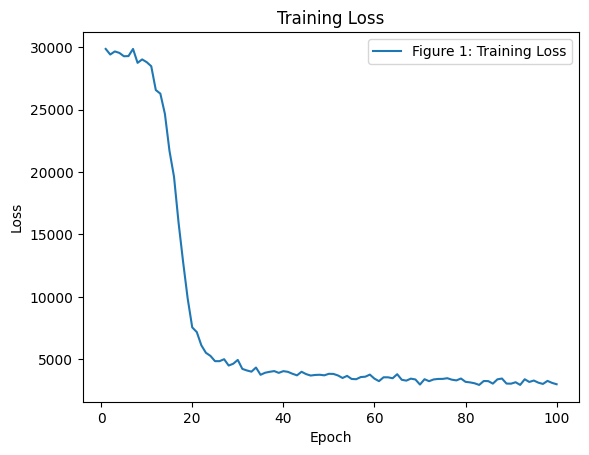

In [25]:
# Training loop
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
plt.plot(range(1, num_epochs + 1), losses, label='Figure 1: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.pause(0.01)

### Model Performance

In [26]:
y_pred=model(Xte)
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression
print(f'RMSE:{np.sqrt(mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy()))}') 

MSE:3422.1513671875
RMSE:58.499156978434314


Once again, the implemented model was unable to tackle the regression problem. All three models' performance metrics are displayed below:

 |-----|  simple TSK  |    ANFIS    |     NN      |
 |-----|--------------|-------------|-------------|
 |MSE  |          2545|         2656|        3422 |
 |RMSE |         50.45|       51.54 |        58.50|

 Even though neural networks are known to be more accurate than fuzzy systems, it was the NN model that performed worse. One could have argued whether there were enough epochs to train the model, but the loss evolution displayed on figure 1 quickly discards this claim, as the model shows only slight variations after epoch 30 and starts behaving somewhat stochastically. In order to try to improve performance, one could start by adding more hidden layers to the model (increasing complexity) and gradually decreasing the number of features of each layer seems reasonable. Further study is required to ascertain if the activation functions, optimization algorithm, learning rate, dropout ratio and batch size were required, but their tune is core to improve performance.

 Increasing model complexity from a simple TSK model to ANFIS also proved to be unsuccessful. However, further tuning of both its fuzzy and neuro inference components is likely to improve results, as described on previous assignment (fuzzy part) and on the above paragraph (neural network part),

 Due to its simplicity, explainability and overall performance, make the TSK fuzzy system the clear option for potential improvements to solve this problem.

## Exercise 3: Classification Problem with ANFIS

For the sake of simplicity, a lesser study was conducted for this exercise, as the methodology and reasoning are very similar to exercise 1.

In [52]:
%reset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


In [53]:

# Regression dataset
diabetes = datasets.fetch_openml("diabetes", version=1, as_frame=True)

X = diabetes.data.values
y = diabetes.target.values

encoder = LabelEncoder()
y = encoder.fit_transform(y)


In [54]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [55]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In [56]:
# Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [57]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

In [58]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

Fuzzy partition coefficient (FPC): 0.500017338180851


In [59]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-4, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

<Figure size 800x600 with 0 Axes>

In [60]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



### ANFIS Solver

In [61]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [62]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()

In [63]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [64]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [65]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))


tensor(0.1528, grad_fn=<MseLossBackward0>)
tensor(0.1526, grad_fn=<MseLossBackward0>)
tensor(0.1510, grad_fn=<MseLossBackward0>)
tensor(0.1507, grad_fn=<MseLossBackward0>)
tensor(0.1506, grad_fn=<MseLossBackward0>)
tensor(0.1502, grad_fn=<MseLossBackward0>)
tensor(0.1498, grad_fn=<MseLossBackward0>)
tensor(0.1497, grad_fn=<MseLossBackward0>)
tensor(0.1498, grad_fn=<MseLossBackward0>)
tensor(0.1499, grad_fn=<MseLossBackward0>)
tensor(0.1498, grad_fn=<MseLossBackward0>)
tensor(0.1497, grad_fn=<MseLossBackward0>)
tensor(0.1495, grad_fn=<MseLossBackward0>)
tensor(0.1495, grad_fn=<MseLossBackward0>)
tensor(0.1494, grad_fn=<MseLossBackward0>)
tensor(0.1493, grad_fn=<MseLossBackward0>)
tensor(0.1491, grad_fn=<MseLossBackward0>)
tensor(0.1489, grad_fn=<MseLossBackward0>)
tensor(0.1489, grad_fn=<MseLossBackward0>)
tensor(0.1488, grad_fn=<MseLossBackward0>)
tensor(0.1470, grad_fn=<MseLossBackward0>)
tensor(0.1478, grad_fn=<MseLossBackward0>)
tensor(0.1466, grad_fn=<MseLossBackward0>)
tensor(0.14

### Model Performance

In [66]:
y_pred, _, _=model(Xte)
#performance metric for classification
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

ACC:0.7662337662337663


Again, model performance is very similar with ANFIS and with a simple TSK (recall accuracy of 74.67%). Due to its simplicity the simple TSK fuzzy system seem preferable, however there is a deeper discussion on the next exercise. 

## Exercise 4: Classification Problem with Neural Networks

For the sake of simplicity, a lesser study was conducted for this exercise, as the methodology and reasoning are very similar to exercise 2.

In [67]:
%reset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas


In [68]:

# Regression dataset
diabetes = datasets.fetch_openml("diabetes", version=1, as_frame=True)

X = diabetes.data.values
y = diabetes.target.values

encoder = LabelEncoder()
y = encoder.fit_transform(y)


In [69]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [70]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [71]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [72]:
num_epochs=100
lr=0.0005
dropout=0.1
batch_size=64

In [73]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [74]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch [1/100], Loss: 0.6810
Epoch [2/100], Loss: 0.6666
Epoch [3/100], Loss: 0.6478
Epoch [4/100], Loss: 0.6174
Epoch [5/100], Loss: 0.5839
Epoch [6/100], Loss: 0.5398
Epoch [7/100], Loss: 0.5112
Epoch [8/100], Loss: 0.4814
Epoch [9/100], Loss: 0.4844
Epoch [10/100], Loss: 0.4651
Epoch [11/100], Loss: 0.4640
Epoch [12/100], Loss: 0.4654
Epoch [13/100], Loss: 0.4391
Epoch [14/100], Loss: 0.4445
Epoch [15/100], Loss: 0.4563
Epoch [16/100], Loss: 0.4493
Epoch [17/100], Loss: 0.4507
Epoch [18/100], Loss: 0.4516
Epoch [19/100], Loss: 0.4537
Epoch [20/100], Loss: 0.4461
Epoch [21/100], Loss: 0.4316
Epoch [22/100], Loss: 0.4517
Epoch [23/100], Loss: 0.4321
Epoch [24/100], Loss: 0.4370
Epoch [25/100], Loss: 0.4295
Epoch [26/100], Loss: 0.4241
Epoch [27/100], Loss: 0.4428
Epoch [28/100], Loss: 0.4250
Epoch [29/100], Loss: 0.4211
Epoch [30/100], Loss: 0.4235
Epoch [31/100], Loss: 0.4290
Epoch [32/100], Loss: 0.4198
Epoch [33/100], Loss: 0.4249
Epoch [34/100], Loss: 0.4217
Epoch [35/100], Loss: 0

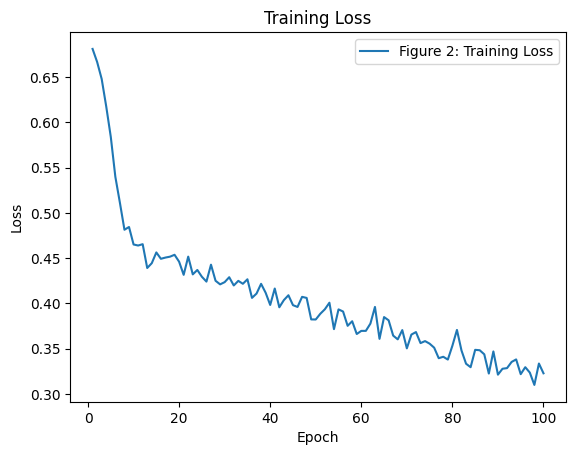

In [75]:
# Training loop
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

plt.plot(range(1, num_epochs + 1), losses, label='Figure 2: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.pause(0.01)

In [76]:
y_pred=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

ACC:0.7402597402597403


 |-----|  simple TSK  |    ANFIS    |     NN      |
 |-----|--------------|-------------|-------------|
 |ACC  |        74.67%|       76.62%|       74.02%|

 Once again, all models perform very similarly and still far from ideal. Improvements procedures are very similar to what was previously described on exercise 2. However, I would point the NN as the one with most potential for improvements, as neural networks are known to be generally more accurate than fuzzy systems and their performance being so close. Furthermore, figure 2 shows that train loss is decreasing throughout epochs and that increasing the number of epochs is likely to make the model reach a better accuracy. Yet, if one is also interested in understanding the decision making behind the model, the ANFIS model would be the adequate choice.  
